In [1]:
config='GS36'
case='MPC001'
freq='1d'

year='2012'


In [2]:
# Parameters
config = "GS36"
case = "MPC002"


In [3]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:46494 Dashboard: http://127.0.0.1:45176/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


In [4]:
## path for mdules

import sys
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/xscale")
import xscale

sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/diags-CMEMS-on-occigen/common-lib/")
import GriddedData

## imports

import numpy as np
import numpy.ma as ma
import xarray as xr
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm
seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

import glob
import os 

%matplotlib inline

In [5]:
if case == 'MPC001':
    if config == 'EU36':
        gridfile='/store/colombo/EU36/EU36-I/coordinates_EU36.nc'
        maskfile='/store/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'
if case == 'MPC002':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_1/coordinates_EU36.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_1/EU36.L150_1_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_1/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_1/GS36.L150_1_mesh_mask.nc'
if case == 'MPC003':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_2/coordinates_EU36.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_2/EU36.L150_2_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_2/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_2/GS36.L150_2_mesh_mask.nc'
 

In [6]:
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']


In [7]:
def filt(w):
    win_box2D = w.window
    win_box2D.set(window='hanning', cutoff=54, dim=['x', 'y'], n=[54, 54])
    bw = win_box2D.boundary_weights(drop_dims=[])
    w_LS = win_box2D.convolve(weights=bw)
    w_SS=w-w_LS
    return w_SS


In [8]:
def hgrad(b,e1u,e2v):
    fe1u=1/e1u
    fse1u=fe1u.squeeze()
    dbxu=(b.shift(x=-1) - b)*fse1u
    fe2v=1/e2v
    fse2v=fe2v.squeeze()
    dbyv=(b.shift(y=-1) - b)*fse2v
    dbx=0.5*(dbxu.shift(x=-1)+dbxu)
    dby=0.5*(dbyv.shift(y=-1)+dbyv)
    hgradb=np.sqrt(dbx*dbx+dby*dby)
    return hgradb
    
    

In [9]:
def plot_fine_scale_hgradb(var,loncrs,latcrs,lon,lat,hpvarm,month,m,config,case):
    ''' map of the averaged fine scale variance
    '''
    if config == 'EU36':
        fig, ax = plt.subplots(1,1,figsize=(10,15))
    if config == 'GS36':
        fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.autoscale(tight=True)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 25, 'color': 'gray'}
    gl.ylabel_style = {'size': 25, 'color': 'gray'}
    
    ax.tick_params('both',labelsize=25)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=mplcm.rainbow,vmin=0,vmax=1,alpha=1)
    ax.contour(lon,lat,hpvarm,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales surface buoyancy horizontal gradient in '+month+' for '+config+'-'+case,fontsize=15)
    plt.savefig('Plots/'+config+'-'+case+'_y'+year+'m'+m+'_fine_scale_horizontal_gradient_buoyancy.png')
  

In [10]:
def plot_hgradb(month):
    date_list=[]
    if month == '03':
        dayf=31
    if month == '09':
        dayf=30
    for day in np.arange(1,dayf+1):
        if day < 10:
            date='y'+str(year)+'m'+str(month)+'d0'+str(day)
        else:
            date='y'+str(year)+'m'+str(month)+'d'+str(day)
        date_list.append(date)
    datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
    for date in date_list:
        fileT=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridT.nc'
        filebuoy='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_buoyancy.nc'
        if not os.path.exists(filebuoy):
            print('Computing '+str(filebuoy))
            !ln -sf $maskfile mesh_hgr.nc
            !ln -sf $maskfile mesh_zgr.nc
            !ulimit -s unlimited; cdfbuoy -t $fileT votemper -s $fileT vosaline -l 1 -o $filebuoy
            !rm mesh*
    filesbuoy='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(month)+'d??.'+str(freq)+'_buoyancy.nc'
    dsbuoy=xr.open_mfdataset(filesbuoy,chunks={'time_counter':1,'y':700,'x':1000})
    buoy=dsbuoy.sobuoy
    buoy_SS=filt(buoy)
    dsmask=xr.open_dataset(maskfile)
    e1u=dsmask.e1u
    e2v=dsmask.e2v
    hgradb_SS=hgrad(buoy_SS,e1u,e2v)
    mask=xr.open_dataset(maskfile)
    tmask=mask.tmask[0,0]
    vtmask=tmask.values
    tmask_filt=filt(tmask)
    vtmask_filt=tmask_filt.values
    hgradb_mask=np.zeros(hgradb_SS.shape)
    for tt in np.arange(hgradb_SS.shape[0]):
        truc=np.squeeze(hgradb_SS[0,:,:].values)        
        truc[np.where(vtmask_filt!=0)]=np.nan
        truc[np.where(vtmask!=1)]=np.nan
        hgradb_mask[tt,:,:]=truc[:,:]   
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=36)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    hgradb_coarse=np.zeros((hgradb_mask.shape[0],latcrs.shape[0],latcrs.shape[1],latcrs.shape[2]))
    for tt in np.arange(hgradb_mask.shape[0]):
        truc=np.squeeze(hgradb_mask[0,:,:])        
        hgradbc = crs.return_ravel(np.asarray(truc))
        hgradb_coarse[tt,:,:,:]=hgradbc 
    hgradb_coarse_stack=np.concatenate(hgradb_coarse,axis=0)
    hgradb_coarse_median=np.nanmedian(hgradb_coarse_stack,axis=0)
    if month == '03':
        plot_fine_scale_hgradb(1e7*hgradb_coarse_median,loncrsm, latcrsm,navlon,navlat,tmask,'March',month,config,case)
    if month == '09':
        plot_fine_scale_hgradb(1e7*hgradb_coarse_median,loncrsm, latcrsm,navlon,navlat,tmask,'September',month,config,case)
        

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi



/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


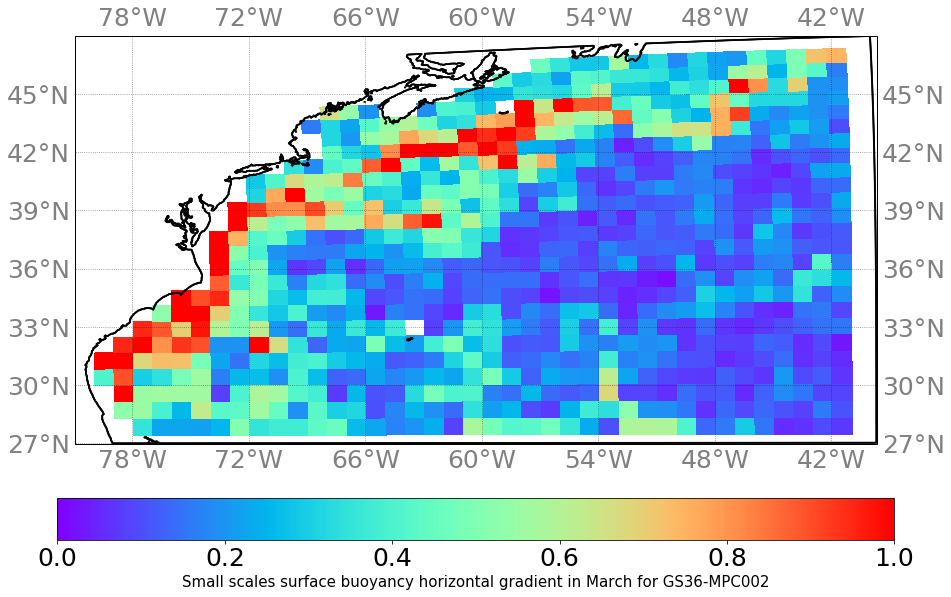

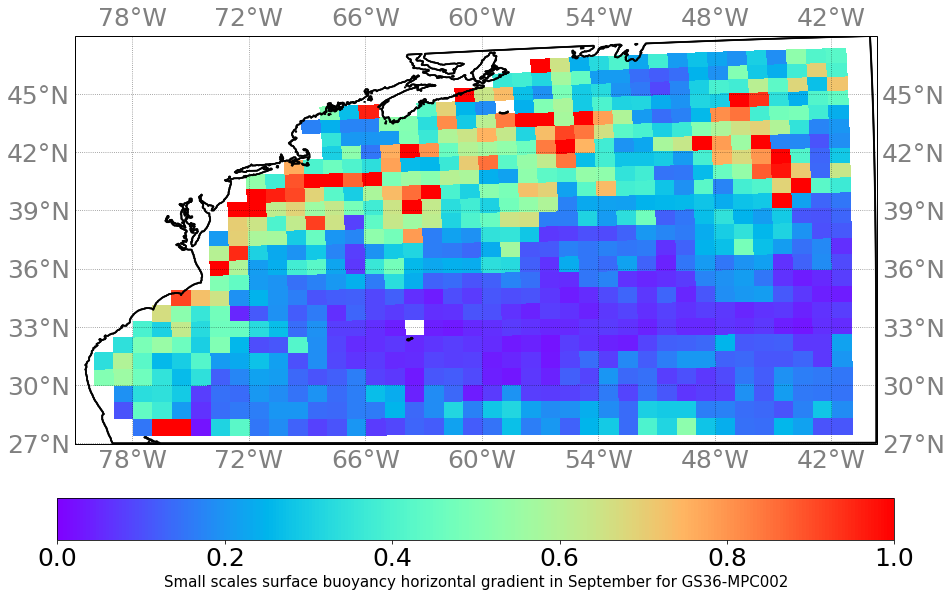

In [11]:
month_list=['03','09']

for month in month_list:
#    if not os.path.exists('Plots/'+config+'-'+case+'_y'+year+'m'+month+'_fine_scale_horizontal_gradient_buoyancy.png'):
        plot_hgradb(month)